In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

from Bayesian2 import BayesianLinearRegression
from Bayesian2 import SklearnBayesianLinearRegression

sns.set_theme()
sns.set_context("notebook")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
dtype_dict = {
    'Date': 'str',
    'FarmName_Pseudo': 'str',
    'SE_Number': 'str',
    'Age': 'Int64',
    'DailyYield': 'float',
    'PreviousDailyYield': 'float',
    'DailyYieldChange': 'float',
    'DaysInMilk': 'float',
    'YearSeason': 'str',
    'LactationNumber': 'float',
    'ExpectedYield': 'float',
    'NormalizedDailyYield': 'float',
    'NormalizedDailyYieldChange': 'float',
    'HeatStress': 'Int64',
    'Temp15Threshold': 'Int64',
    'HW': 'Int64',
    'cum_HW': 'Int64',
    'MeanTemperature': 'float',
    'MeanTHI_adj': 'float',
    'FarmHeatStressMilkProduction': 'float'
}

milk_data = pd.read_csv('../Data/MergedData/BLRMilkFarmYieldData.csv', dtype=dtype_dict)
milk_data['Date'] = pd.to_datetime(milk_data['Date'], format='%Y-%m-%d')
milk_data.head(-5)

,Date,FarmName_Pseudo,SE_Number,Age,LactationNumber,DaysInMilk,YearSeason,DailyYield,PreviousDailyYield,DailyYieldChange,ExpectedYield,NormalizedDailyYield,NormalizedDailyYieldChange,HeatStress,Temp15Threshold,HW,cum_HW,MeanTemperature,MeanTHI_adj,FarmHeatStressMilkProduction
0,2022-01-01,a624fb9a,SE-064c0cec-1189,3095,7.0,191.0,2022-1,30.77,0.00,0.00,29.739372,1.034655,0.000000,0,0,0,0,-3.025000,28.012944,0.015268
1,2022-01-02,a624fb9a,SE-064c0cec-1189,3096,7.0,192.0,2022-1,48.22,30.77,17.45,29.692059,1.624003,0.587699,0,0,0,0,-0.279167,32.898193,0.015268
2,2022-01-03,a624fb9a,SE-064c0cec-1189,3097,7.0,193.0,2022-1,30.53,48.22,-17.69,29.644756,1.029862,-0.596733,0,0,0,0,2.033333,36.760487,0.015268
3,2022-01-04,a624fb9a,SE-064c0cec-1189,3098,7.0,194.0,2022-1,42.26,30.53,11.73,29.597463,1.427825,0.396318,0,0,0,0,0.066667,31.939524,0.015268
4,2022-01-05,a624fb9a,SE-064c0cec-1189,3099,7.0,195.0,2022-1,38.49,42.26,-3.77,29.550181,1.302530,-0.127580,0,0,0,0,-3.700000,26.498206,0.015268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487083,2023-06-03,f454e660,SE-fcdf259d-0044-0,4150,10.0,347.0,2023-3,12.67,15.75,-3.08,11.811455,1.072687,-0.260764,0,1,0,0,12.666667,53.132530,0.005465
487084,2023-06-04,f454e660,SE-fcdf259d-0044-0,4151,10.0,348.0,2023-3,22.31,12.67,9.64,11.750492,1.898644,0.820391,0,1,0,0,13.079167,56.726870,0.005465
487085,2023-06-05,f454e660,SE-fcdf259d-0044-0,4152,10.0,349.0,2023-3,12.84,22.31,-9.47,11.689810,1.098393,-0.810107,0,1,0,0,14.237500,58.482418,0.005465
487086,2023-06-06,f454e660,SE-fcdf259d-0044-0,4153,10.0,350.0,2023-3,9.47,12.84,-3.37,11.629408,0.814315,-0.289783,0,1,0,0,15.345833,60.546358,0.005465


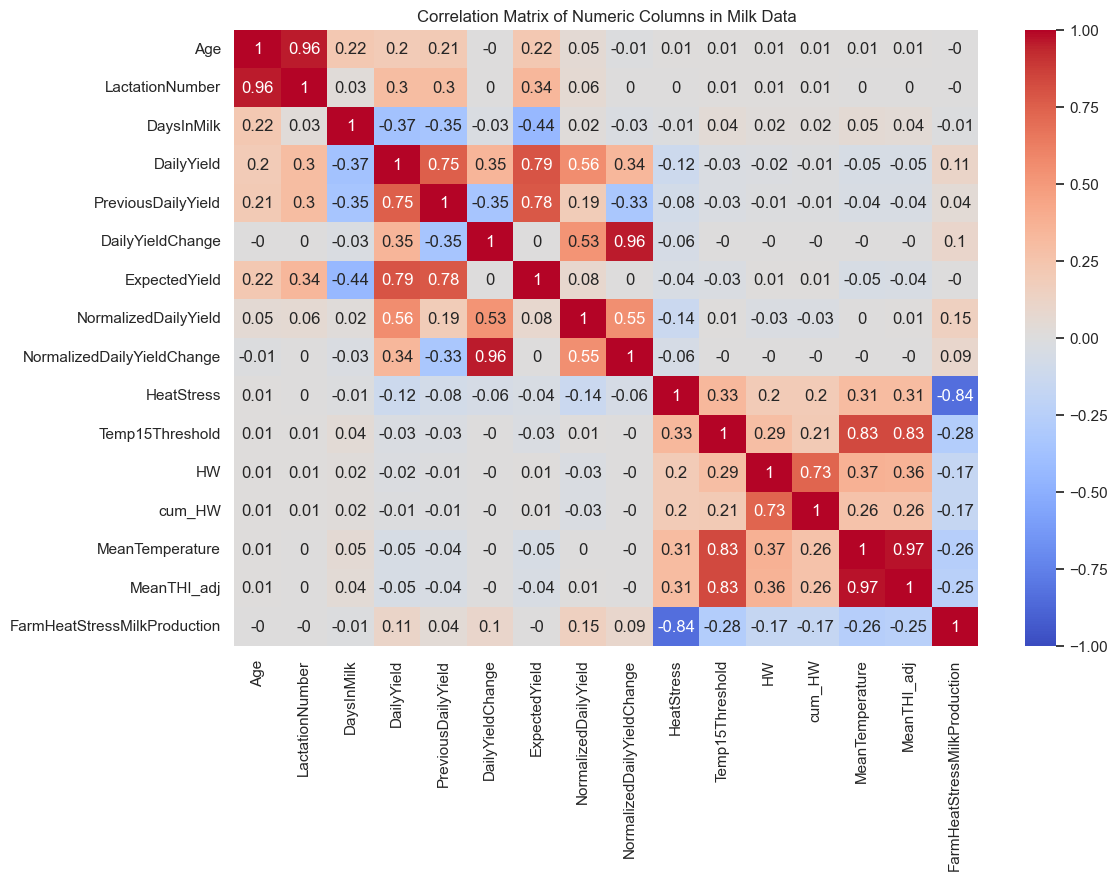

In [19]:
# Filter out only numeric columns
numeric_cols = milk_data.select_dtypes(include=['float64', 'int64']).columns
milk_data_numeric = milk_data[numeric_cols]

# Calculate the correlation matrix
corr_matrix = milk_data_numeric.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix.round(2), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numeric Columns in Milk Data')
plt.show()

In [20]:
# Output the correlation matrix here in the notebook with two decimals
corr_matrix.round(2)

,Age,LactationNumber,DaysInMilk,DailyYield,PreviousDailyYield,DailyYieldChange,ExpectedYield,NormalizedDailyYield,NormalizedDailyYieldChange,HeatStress,Temp15Threshold,HW,cum_HW,MeanTemperature,MeanTHI_adj,FarmHeatStressMilkProduction
Age,1.00,0.96,0.22,0.20,0.21,-0.00,0.22,0.05,-0.01,0.01,0.01,0.01,0.01,0.01,0.01,-0.00
LactationNumber,0.96,1.00,0.03,0.30,0.30,0.00,0.34,0.06,0.00,0.00,0.01,0.01,0.01,0.00,0.00,-0.00
DaysInMilk,0.22,0.03,1.00,-0.37,-0.35,-0.03,-0.44,0.02,-0.03,-0.01,0.04,0.02,0.02,0.05,0.04,-0.01
DailyYield,0.20,0.30,-0.37,1.00,0.75,0.35,0.79,0.56,0.34,-0.12,-0.03,-0.02,-0.01,-0.05,-0.05,0.11
PreviousDailyYield,0.21,0.30,-0.35,0.75,1.00,-0.35,0.78,0.19,-0.33,-0.08,-0.03,-0.01,-0.01,-0.04,-0.04,0.04
DailyYieldChange,-0.00,0.00,-0.03,0.35,-0.35,1.00,0.00,0.53,0.96,-0.06,-0.00,-0.00,-0.00,-0.00,-0.00,0.10
ExpectedYield,0.22,0.34,-0.44,0.79,0.78,0.00,1.00,0.08,0.00,-0.04,-0.03,0.01,0.01,-0.05,-0.04,-0.00
NormalizedDailyYield,0.05,0.06,0.02,0.56,0.19,0.53,0.08,1.00,0.55,-0.14,0.01,-0.03,-0.03,0.00,0.01,0.15
NormalizedDailyYieldChange,-0.01,0.00,-0.03,0.34,-0.33,0.96,0.00,0.55,1.00,-0.06,-0.00,-0.00,-0.00,-0.00,-0.00,0.09
HeatStress,0.01,0.00,-0.01,-0.12,-0.08,-0.06,-0.04,-0.14,-0.06,1.00,0.33,0.20,0.20,0.31,0.31,-0.84


## Farm a624fb9a

In [21]:
# Filter data for a specific farm
farm = 'a624fb9a'
daily_farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm].copy()

# Filter data for HeatStress condition
data_heatstress = daily_farm_data[daily_farm_data['HeatStress'] == 1].copy()

# Extract and transform the 'YearSeason' to numeric encoding for the season
def extract_season_numeric(yearseason):
    return int(yearseason.split('-')[1])

data_heatstress['YearSeason'] = data_heatstress['YearSeason'].apply(extract_season_numeric)

# Ensure the features are float type
features_to_scale = ['MeanTemperature', 'MeanTHI_adj']
data_heatstress[features_to_scale] = data_heatstress[features_to_scale].astype(float)

# Scale features
scaler = StandardScaler()
data_heatstress[features_to_scale] = scaler.fit_transform(data_heatstress[features_to_scale])

# Define the feature pairs
temp_pair = ['MeanTemperature', 'MeanTHI_adj']
hw_pair = ['HW', 'cum_HW']

# Function to fit the Bayesian Linear Regression model for cross-validation
def fit_bayesian_model_cv(data, selected_feats):
    # Calculate global priors from the HeatStress data
    global_mean = data['NormalizedDailyYield'].mean()
    global_variance = data['NormalizedDailyYield'].var()
    if global_variance < 1e-6:
        global_variance = 1e-6
    global_beta = 1 / global_variance

    # Calculate prior means for the features based on the HeatStress data
    prior_mean_values = [data[feature].mean() for feature in selected_feats]

    # Define priors with stronger regularization
    prior_mean = np.array([global_mean] + prior_mean_values).reshape(-1, 1)
    prior_cov = np.eye(len(selected_feats) + 1) * 0.1

    model = SklearnBayesianLinearRegression(
        dataframe=data,
        subject_name='farm',
        selected_features=selected_feats,
        target='NormalizedDailyYield',
        prior_mean=prior_mean,
        prior_cov=prior_cov,
        beta=global_beta
    )

    return model

# Function to perform cross-validation and find the best feature combination
def find_best_feature_combination(data, temp_pair, hw_pair):
    best_features = None
    lowest_mse = float('inf')

    # Iterate over all combinations of temp and hw pairs, always include YearSeason
    for temp_feature in temp_pair:
        for hw_feature in hw_pair:
            features = [temp_feature, hw_feature, 'YearSeason']
            valid_features = [feat for feat in features if data[feat].std() > 0]
            
            if not valid_features:
                print(f"No valid features left for cross-validation with features {features}. Skipping...")
                continue

            X_val = data[valid_features].astype(np.float64).values
            y_val = data['NormalizedDailyYield'].astype(np.float64).values

            model = fit_bayesian_model_cv(data, valid_features)

            cv_scores = cross_val_score(model, X_val, y_val, cv=5, scoring='neg_mean_squared_error')
            mean_cv_score = -cv_scores.mean()
            std_cv_score = cv_scores.std()

            print(f"Cross-validation MSE for features {valid_features}: {mean_cv_score:.4f} ± {std_cv_score:.4f}")

            if mean_cv_score < lowest_mse:
                lowest_mse = mean_cv_score
                best_features = valid_features

    return best_features, lowest_mse

# Find the best feature combination
best_features, best_mse = find_best_feature_combination(data_heatstress, temp_pair, hw_pair)
print(f"Best features: {best_features}, with MSE: {best_mse}")

# Function to fit model on entire dataset and calculate yield change for each cow
def fit_model_and_calculate_yield_change(data, selected_feats):
    cow_ids = data['SE_Number'].unique()
    yield_changes = {}

    for cow in cow_ids:
        cow_data = data[data['SE_Number'] == cow]

        # Calculate cow's individual mean and variance for NormalizedDailyYield
        cow_mean = cow_data['NormalizedDailyYield'].mean()
        cow_variance = cow_data['NormalizedDailyYield'].var()
        if cow_variance < 1e-6:
            cow_variance = 1e-6  # Set a minimum threshold to avoid division by zero
        beta = 1 / cow_variance

        # Calculate prior means for the features based on the entire HeatStress data
        prior_mean_values = [data_heatstress[feature].mean() for feature in selected_feats]

        # Define priors
        prior_mean = np.array([cow_mean] + prior_mean_values).reshape(-1, 1)
        prior_cov = np.eye(len(selected_feats) + 1) * 0.1  # Stronger regularization

        # Initialize and fit the model on the entire dataset with the selected features
        model = BayesianLinearRegression(
            dataframe=cow_data,
            subject_name=cow,
            selected_features=selected_feats,
            target='NormalizedDailyYield',
            prior_mean=prior_mean,
            prior_cov=prior_cov,
            beta=beta
        )
        result = model.fit_model()

        # Store the yield change for the cow
        yield_changes[cow] = result['Off-set']['mu']

    return yield_changes

# Fit the model and calculate yield changes for all cows using the best features
yield_changes_heatstress = fit_model_and_calculate_yield_change(data_heatstress, best_features)

# Create results DataFrame
results_df = pd.DataFrame({
    'SE_Number': yield_changes_heatstress.keys(),
    'Yield HeatStress': yield_changes_heatstress.values()
})
results_df

Cross-validation MSE for features ['MeanTemperature', 'HW', 'YearSeason']: 0.0416 ± 0.0092
Cross-validation MSE for features ['MeanTemperature', 'cum_HW', 'YearSeason']: 0.0417 ± 0.0092
Cross-validation MSE for features ['MeanTHI_adj', 'HW', 'YearSeason']: 0.0416 ± 0.0091
Cross-validation MSE for features ['MeanTHI_adj', 'cum_HW', 'YearSeason']: 0.0416 ± 0.0091
Best features: ['MeanTHI_adj', 'HW', 'YearSeason'], with MSE: 0.041604666553892986


,SE_Number,Yield HeatStress
0,SE-064c0cec-1189,1.272498
1,SE-30dc5787-1389,1.046770
2,SE-30dc5787-1396,0.945466
3,SE-30dc5787-1402,1.171054
4,SE-a624fb9a-1039,1.023081
...,...,...
131,SE-a624fb9a-1491,0.994785
132,SE-a624fb9a-1493,1.003768
133,SE-a624fb9a-1496,0.992131
134,SE-a624fb9a-1503,0.995772


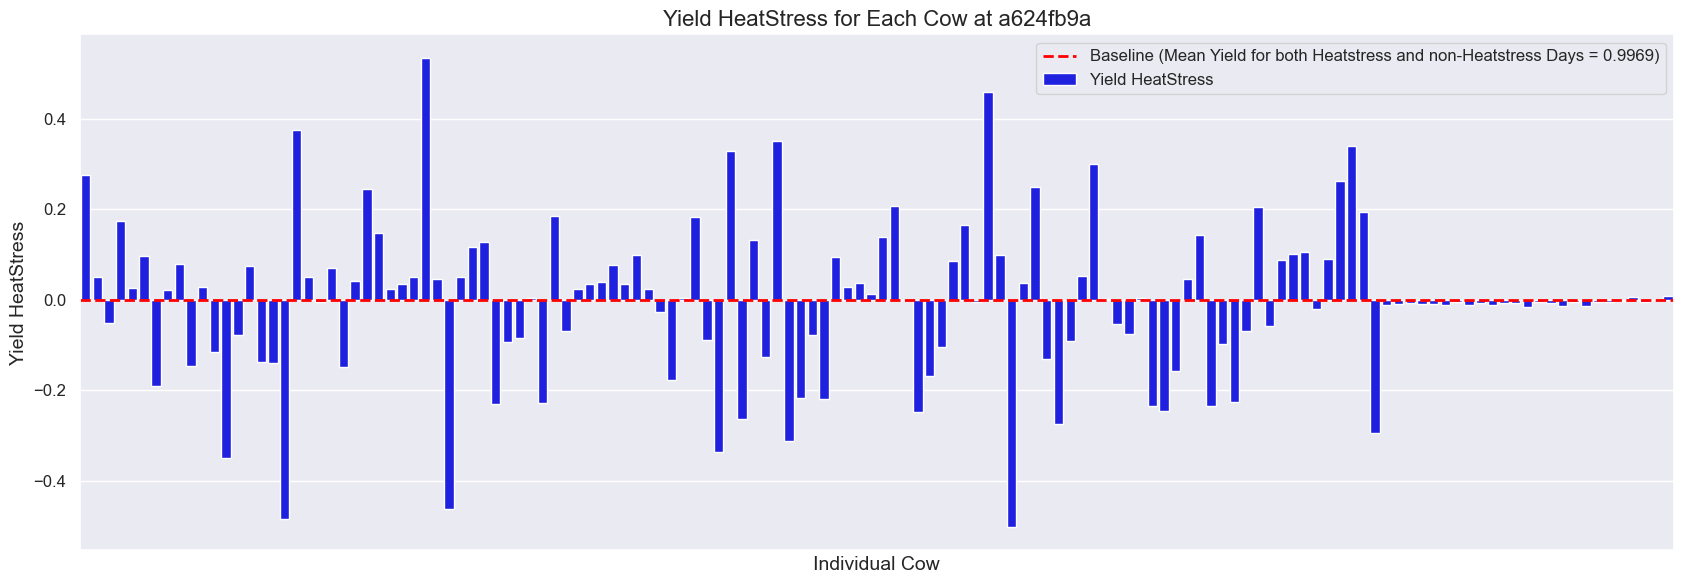

In [22]:
# Calculate the baseline
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean()

# Calculate deviations from the baseline
results_df['Deviation from Baseline'] = results_df['Yield HeatStress'] - baseline_yield_change

# Plotting
plt.figure(figsize=(17, 6))
sns.barplot(x=results_df.index, y=results_df['Deviation from Baseline'], color='blue', label='Yield HeatStress')

# Add baseline line
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for both Heatstress and non-Heatstress Days = {baseline_yield_change:.4f})')

# Formatting the plot
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Yield HeatStress', fontsize=14)
plt.title(f'Yield HeatStress for Each Cow at {farm}', fontsize=16)


plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

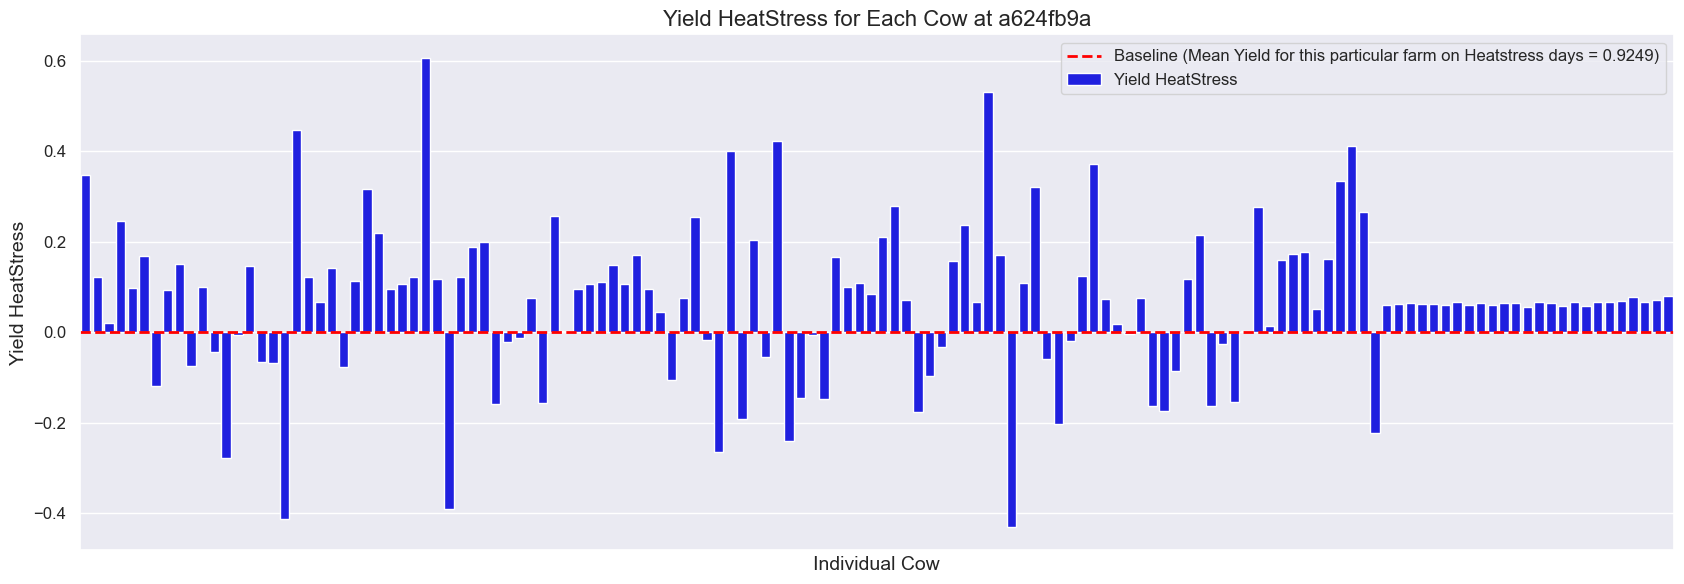

In [23]:
# Calculate the baseline (mean yield change)
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean() + data_heatstress['FarmHeatStressMilkProduction'].mean()

# Calculate deviations from the baseline
results_df['Deviation from Baseline'] = results_df['Yield HeatStress'] - baseline_yield_change

# Plotting
plt.figure(figsize=(17, 6))
sns.barplot(x=results_df.index, y=results_df['Deviation from Baseline'], color='blue', label='Yield HeatStress')

# Add baseline line
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for this particular farm on Heatstress days = {baseline_yield_change:.4f})')

# Formatting the plot
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Yield HeatStress', fontsize=14)
plt.title(f'Yield HeatStress for Each Cow at {farm}', fontsize=16)


plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

# Now we do the same for the rest of the farms

## Farm 5c06d92d

In [24]:
# Select a farm and filter data for that farm
farm = '5c06d92d'  
daily_farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm].copy()

# Filter data for HeatStress condition
data_heatstress = daily_farm_data[daily_farm_data['HeatStress'] == 1].copy()

# Extract and transform the 'YearSeason' to numeric encoding
def extract_season_numeric(yearseason):
    return int(yearseason.split('-')[1])

# Apply the transformation and keep both the original and new columns
data_heatstress['YearSeason_numeric'] = data_heatstress['YearSeason'].apply(extract_season_numeric)

# Drop the original 'YearSeason' column if not needed
data_heatstress.drop(columns=['YearSeason'], inplace=True)

# Rename the new column to 'YearSeason'
data_heatstress.rename(columns={'YearSeason_numeric': 'YearSeason'}, inplace=True)

# Ensure the features to be scaled are float type
features_to_scale = ['Age', 'DaysInMilk', 'LactationNumber', 'MeanTemperature', 'MeanTHI_adj']
data_heatstress[features_to_scale] = data_heatstress[features_to_scale].astype(float)

# Split data into train and validation sets
train_heatstress, val_heatstress = train_test_split(data_heatstress, test_size=0.3, random_state=42)

# Scale features before the loop
scaler = StandardScaler()
train_heatstress.loc[:, features_to_scale] = scaler.fit_transform(train_heatstress[features_to_scale])
val_heatstress.loc[:, features_to_scale] = scaler.transform(val_heatstress[features_to_scale])

# All possible features excluding 'HeatStress'
all_feats = ['HW', 'cum_HW', 'DaysInMilk', 'LactationNumber', 'MeanTemperature', 'MeanTHI_adj', 'Age', 'YearSeason']

def generate_feature_combinations():
    combos = []
    for hw in ['HW', 'cum_HW']:
        for lact in ['LactationNumber', 'Age']:
            for temp in ['MeanTemperature', 'MeanTHI_adj']:
                remaining_feats = set(all_feats) - {'HW', 'cum_HW', 'LactationNumber', 'Age', 'MeanTemperature', 'MeanTHI_adj'}
                remaining_feats.add(hw)
                remaining_feats.add(lact)
                remaining_feats.add(temp)
                combos.append(list(remaining_feats))
    return combos

feature_combinations = generate_feature_combinations()

# Dictionary to save posterior results
all_cows_results = {f'combo_{i+1}': {} for i in range(len(feature_combinations))}

# Function to fit the Bayesian Linear Regression model
def fit_bayesian_model(daily_cow_data, selected_feats, cow):
    cow_mean = daily_cow_data['NormalizedDailyYield'].mean()
    cow_variance = daily_cow_data['NormalizedDailyYield'].var()
    if cow_variance < 1e-6:
        cow_variance = 1e-6  # Set a minimum threshold to avoid division by zero
    beta = 1 / cow_variance

    # Calculate prior means and standard deviations for the features
    prior_mean_values = [daily_cow_data[feature].mean() for feature in selected_feats]
    prior_std_values = [daily_cow_data[feature].std() for feature in selected_feats]

    # Define priors
    prior_mean = np.array([cow_mean] + prior_mean_values).reshape(-1, 1)
    prior_cov = np.eye(len(selected_feats) + 1) * 0.01  # Stronger regularization

    # Print prior means and standard deviations
    print(f"\nPrior Mean and Standard Deviation for cow {cow} with features {selected_feats}:\n")
    for feature, mean, std in zip(['Off-set'] + selected_feats, prior_mean.flatten(), [np.sqrt(cow_variance)] + prior_std_values):
        print(f"{feature}: mean = {mean}, std_dev = {std}")

    # Instantiate and fit Bayesian Linear Regression model
    BM = BayesianLinearRegression(
        dataframe=daily_cow_data,
        subject_name=cow,
        selected_features=selected_feats,
        target='NormalizedDailyYield',
        subject_type='cow',
        prior_mean=prior_mean,
        prior_cov=prior_cov,
        beta=beta,
        baseline_feature='FarmHeatStressMilkProduction'
    )
    
    try:
        result = BM.fit_model()
    except ValueError as e:
        if str(e) == "math domain error":
            result = {}
            for i in range(BM.Phi.shape[1]):
                mu = BM.posterior_mean[i]
                variance = BM.posterior_cov[i, i]
                if variance < 0:
                    variance = 0  # Ensure variance is non-negative
                sigma = math.sqrt(variance)
                feature_name = "Off-set" if i == 0 else BM.selected_features[i - 1]
                result[feature_name] = {"mu": mu[0], "sigma": sigma}

    # Print posterior means and standard deviations
    print(f"\nPosterior Mean and Standard Deviation for cow {cow} with features {selected_feats}:\n")
    for feature, stats in result.items():
        print(f"{feature}: mean = {stats['mu']}, std_dev = {stats['sigma']}")

    return result

# Function to randomly select one cow and fit the model
def fit_model_for_random_cow(selected_feats, condition):
    cows_list = train_heatstress['SE_Number'].unique()
    
    random_cow = np.random.choice(cows_list)
    daily_cow_data = train_heatstress[train_heatstress['SE_Number'] == random_cow].copy()
    
    print(f"\nSelected random cow: {random_cow} for condition: {condition} and features: {selected_feats}")
    
    return fit_bayesian_model(daily_cow_data, selected_feats, random_cow)

# Iterate over each combination and fit the model for one random cow in each condition
for combo_index, selected_feats in enumerate(feature_combinations, start=1):
    print(f"\nProcessing combination {combo_index}/{len(feature_combinations)}: {selected_feats}")
    all_cows_results[f'combo_{combo_index}'] = fit_model_for_random_cow(selected_feats, "HeatStress")


Processing combination 1/8: ['MeanTemperature', 'LactationNumber', 'HW', 'YearSeason', 'DaysInMilk']

Selected random cow: SE-5c06d92d-3090 for condition: HeatStress and features: ['MeanTemperature', 'LactationNumber', 'HW', 'YearSeason', 'DaysInMilk']

Prior Mean and Standard Deviation for cow SE-5c06d92d-3090 with features ['MeanTemperature', 'LactationNumber', 'HW', 'YearSeason', 'DaysInMilk']:

Off-set: mean = 0.7481067808699255, std_dev = 0.23221355620488812
MeanTemperature: mean = 0.2832997353360471, std_dev = 0.9901114534753892
LactationNumber: mean = -0.8638978162137767, std_dev = 0.3445551590668555
HW: mean = 0.3076923076923077, std_dev = 0.48038446141526137
YearSeason: mean = 2.8461538461538463, std_dev = 0.3755338080994054
DaysInMilk: mean = 1.413412708060405, std_dev = 0.4543352648773676


TypeError: BayesianLinearRegression.__init__() got an unexpected keyword argument 'baseline_feature'

In [ ]:
# Function to fit the Bayesian Linear Regression model for cross-validation
def fit_bayesian_model_cv(daily_cow_data, selected_feats):
    cow_mean = daily_cow_data['NormalizedDailyYield'].mean()
    cow_variance = daily_cow_data['NormalizedDailyYield'].var()
    if cow_variance < 1e-6:
        cow_variance = 1e-6  # Set a minimum threshold to avoid division by zero
    beta = 1 / cow_variance

    prior_mean_values = [daily_cow_data[feature].mean() for feature in selected_feats]
    prior_mean = np.array([cow_mean] + prior_mean_values).reshape(-1, 1)
    prior_cov = np.eye(len(selected_feats) + 1) * 0.01  # Stronger regularization

    model = SklearnBayesianLinearRegression(
        dataframe=daily_cow_data,
        subject_name='farm',
        selected_features=selected_feats,
        target='NormalizedDailyYield',
        subject_type='cow',
        prior_mean=prior_mean,
        prior_cov=prior_cov,
        beta=beta,
        baseline_feature='FarmHeatStressMilkProduction'
    )

    return model

# Function to perform cross-validation
def cross_validate_feature_combinations(val_data, feature_combinations):
    best_features = None
    lowest_mse = float('inf')

    for features in feature_combinations:
        val_data_scaled = val_data.copy()

        X_val = val_data_scaled[features].astype(np.float64).values
        y_val = val_data_scaled['NormalizedDailyYield'].astype(np.float64).values

        model = fit_bayesian_model_cv(val_data_scaled, features)

        cv_scores = cross_val_score(model, X_val, y_val, cv=5, scoring='neg_mean_squared_error')
        mean_cv_score = -cv_scores.mean()
        std_cv_score = cv_scores.std()

        print(f"Cross-validation MSE for features {features}: {mean_cv_score:.4f} ± {std_cv_score:.4f}")

        if mean_cv_score < lowest_mse:
            lowest_mse = mean_cv_score
            best_features = features

    return best_features, lowest_mse

# Perform cross-validation and select the best feature combination
best_features_heatstress, lowest_mse_heatstress = cross_validate_feature_combinations(val_heatstress, feature_combinations)
print(f"\nThe best feature combination in terms of the lowest MSE for HeatStress is {best_features_heatstress} with an MSE of {lowest_mse_heatstress:.4f}.\n")

Cross-validation MSE for features ['YearSeason', 'HW', 'MeanTemperature', 'LactationNumber', 'DaysInMilk']: 0.0617 ± 0.0038
Cross-validation MSE for features ['YearSeason', 'HW', 'LactationNumber', 'DaysInMilk', 'MeanTHI_adj']: 0.0626 ± 0.0045
Cross-validation MSE for features ['YearSeason', 'HW', 'MeanTemperature', 'DaysInMilk', 'Age']: 0.0617 ± 0.0038
Cross-validation MSE for features ['YearSeason', 'HW', 'DaysInMilk', 'MeanTHI_adj', 'Age']: 0.0626 ± 0.0045
Cross-validation MSE for features ['YearSeason', 'MeanTemperature', 'LactationNumber', 'DaysInMilk', 'cum_HW']: 0.0614 ± 0.0039
Cross-validation MSE for features ['YearSeason', 'LactationNumber', 'DaysInMilk', 'MeanTHI_adj', 'cum_HW']: 0.0622 ± 0.0044
Cross-validation MSE for features ['Age', 'YearSeason', 'MeanTemperature', 'DaysInMilk', 'cum_HW']: 0.0614 ± 0.0039
Cross-validation MSE for features ['Age', 'YearSeason', 'DaysInMilk', 'MeanTHI_adj', 'cum_HW']: 0.0623 ± 0.0044

The best feature combination in terms of the lowest MSE

In [ ]:
# Function to fit model on entire dataset and calculate yield change for each cow
def fit_model_and_calculate_yield_change(data, features):
    cow_ids = data['SE_Number'].unique()
    yield_changes = {}
    
    for cow in cow_ids:
        cow_data = data[data['SE_Number'] == cow]
        
        # Calculate cow's individual mean and variance for NormalizedDailyYield
        cow_mean = cow_data['NormalizedDailyYield'].mean()
        cow_variance = cow_data['NormalizedDailyYield'].var()
        if cow_variance < 1e-6:
            cow_variance = 1e-6  # Set a minimum threshold to avoid division by zero
        beta = 1 / cow_variance

        # Calculate prior means for the features
        prior_mean_values = [cow_data[feature].mean() for feature in features]
        
        # Define priors
        prior_mean = np.array([cow_mean] + prior_mean_values).reshape(-1, 1)
        prior_cov = np.eye(len(features) + 1) * 0.01  # Stronger regularization
        
        # Initialize and fit the model on the entire dataset with the best features
        model = BayesianLinearRegression(
            dataframe=cow_data,
            subject_name=cow,
            selected_features=features,
            target='NormalizedDailyYield',
            subject_type='cow',
            prior_mean=prior_mean,
            prior_cov=prior_cov,
            beta=beta,
            baseline_feature='FarmHeatStressMilkProduction'
        )
        result = model.fit_model()
        
        # Store the yield change for the cow
        yield_changes[cow] = result['Off-set']['mu']
    
    return yield_changes

# Fit the best model on the entire dataset using the best features from Block 2
yield_changes_heatstress = fit_model_and_calculate_yield_change(
    data_heatstress.copy(), best_features_heatstress
)

# Create results DataFrame
results_df = pd.DataFrame({
    'SE_Number': yield_changes_heatstress.keys(),
    'Yield Change HeatStress': yield_changes_heatstress.values()
})

results_df

,SE_Number,Yield Change HeatStress
0,SE-5c06d92d-2000,1.003904
1,SE-5c06d92d-2016,1.000897
2,SE-5c06d92d-2055,1.009466
3,SE-5c06d92d-2058,1.059319
4,SE-5c06d92d-2211,0.985751
...,...,...
438,SE-5c06d92d-3474,0.970340
439,SE-5c06d92d-3475,0.992385
440,SE-5c06d92d-3478,0.994902
441,SE-5c06d92d-3482,0.998698


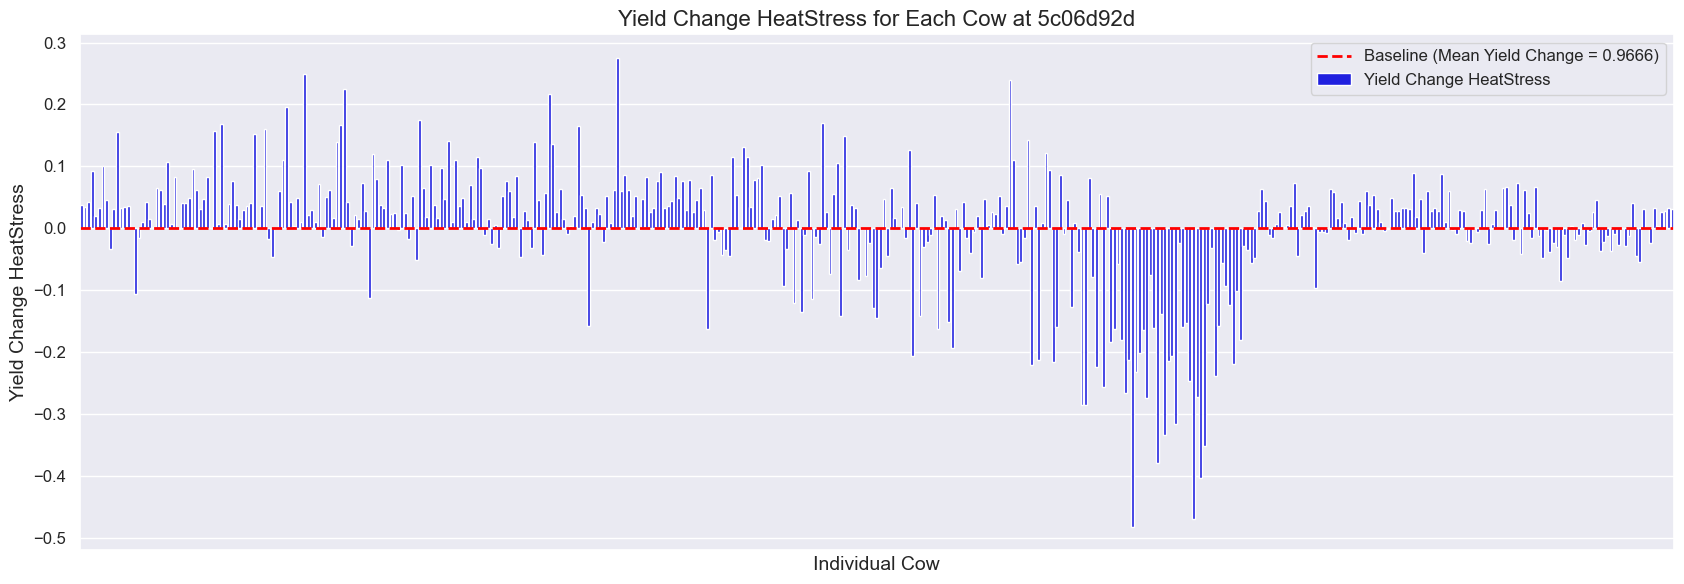

In [ ]:
# Calculate the baseline (mean yield change)
baseline_yield_change = results_df['Yield Change HeatStress'].mean()

# Calculate deviations from the baseline
results_df['Deviation from Baseline'] = results_df['Yield Change HeatStress'] - baseline_yield_change

# Plotting
plt.figure(figsize=(17, 6))
sns.barplot(x=results_df.index, y=results_df['Deviation from Baseline'], color='blue', label='Yield Change HeatStress')

# Add baseline line
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield Change = {baseline_yield_change:.4f})')

# Formatting the plot
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Yield Change HeatStress', fontsize=14)
plt.title(f'Yield Change HeatStress for Each Cow at {farm}', fontsize=16)


plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

## Farm 752efd72

In [ ]:
# Select a farm and filter data for that farm
farm = '752efd72'  
daily_farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm].copy()

# Filter data for HeatStress condition
data_heatstress = daily_farm_data[daily_farm_data['HeatStress'] == 1].copy()

# Extract and transform the 'YearSeason' to numeric encoding
def extract_season_numeric(yearseason):
    return int(yearseason.split('-')[1])

# Apply the transformation and keep both the original and new columns
data_heatstress['YearSeason_numeric'] = data_heatstress['YearSeason'].apply(extract_season_numeric)

# Drop the original 'YearSeason' column if not needed
data_heatstress.drop(columns=['YearSeason'], inplace=True)

# Rename the new column to 'YearSeason'
data_heatstress.rename(columns={'YearSeason_numeric': 'YearSeason'}, inplace=True)

# Ensure the features to be scaled are float type
features_to_scale = ['Age', 'DaysInMilk', 'LactationNumber', 'MeanTemperature', 'MeanTHI_adj']
data_heatstress[features_to_scale] = data_heatstress[features_to_scale].astype(float)

# Split data into train and validation sets
train_heatstress, val_heatstress = train_test_split(data_heatstress, test_size=0.3, random_state=42)

# Scale features before the loop
scaler = StandardScaler()
train_heatstress.loc[:, features_to_scale] = scaler.fit_transform(train_heatstress[features_to_scale])
val_heatstress.loc[:, features_to_scale] = scaler.transform(val_heatstress[features_to_scale])

# All possible features excluding 'HeatStress'
all_feats = ['HW', 'cum_HW', 'DaysInMilk', 'LactationNumber', 'MeanTemperature', 'MeanTHI_adj', 'Age', 'YearSeason']

def generate_feature_combinations():
    combos = []
    for hw in ['HW', 'cum_HW']:
        for lact in ['LactationNumber', 'Age']:
            for temp in ['MeanTemperature', 'MeanTHI_adj']:
                remaining_feats = set(all_feats) - {'HW', 'cum_HW', 'LactationNumber', 'Age', 'MeanTemperature', 'MeanTHI_adj'}
                remaining_feats.add(hw)
                remaining_feats.add(lact)
                remaining_feats.add(temp)
                combos.append(list(remaining_feats))
    return combos

feature_combinations = generate_feature_combinations()

# Dictionary to save posterior results
all_cows_results = {f'combo_{i+1}': {} for i in range(len(feature_combinations))}

# Function to fit the Bayesian Linear Regression model
def fit_bayesian_model(daily_cow_data, selected_feats, cow):
    cow_mean = daily_cow_data['NormalizedDailyYield'].mean()
    cow_variance = daily_cow_data['NormalizedDailyYield'].var()
    if cow_variance < 1e-6:
        cow_variance = 1e-6  # Set a minimum threshold to avoid division by zero
    beta = 1 / cow_variance

    # Calculate prior means and standard deviations for the features
    prior_mean_values = [daily_cow_data[feature].mean() for feature in selected_feats]
    prior_std_values = [daily_cow_data[feature].std() for feature in selected_feats]

    # Define priors
    prior_mean = np.array([cow_mean] + prior_mean_values).reshape(-1, 1)
    prior_cov = np.eye(len(selected_feats) + 1) * 0.01  # Stronger regularization

    # Print prior means and standard deviations
    print(f"\nPrior Mean and Standard Deviation for cow {cow} with features {selected_feats}:\n")
    for feature, mean, std in zip(['Off-set'] + selected_feats, prior_mean.flatten(), [np.sqrt(cow_variance)] + prior_std_values):
        print(f"{feature}: mean = {mean}, std_dev = {std}")

    # Instantiate and fit Bayesian Linear Regression model
    BM = BayesianLinearRegression(
        dataframe=daily_cow_data,
        subject_name=cow,
        selected_features=selected_feats,
        target='NormalizedDailyYield',
        subject_type='cow',
        prior_mean=prior_mean,
        prior_cov=prior_cov,
        beta=beta,
        baseline_feature='FarmHeatStressMilkProduction'
    )
    
    try:
        result = BM.fit_model()
    except ValueError as e:
        if str(e) == "math domain error":
            result = {}
            for i in range(BM.Phi.shape[1]):
                mu = BM.posterior_mean[i]
                variance = BM.posterior_cov[i, i]
                if variance < 0:
                    variance = 0  # Ensure variance is non-negative
                sigma = math.sqrt(variance)
                feature_name = "Off-set" if i == 0 else BM.selected_features[i - 1]
                result[feature_name] = {"mu": mu[0], "sigma": sigma}

    # Print posterior means and standard deviations
    print(f"\nPosterior Mean and Standard Deviation for cow {cow} with features {selected_feats}:\n")
    for feature, stats in result.items():
        print(f"{feature}: mean = {stats['mu']}, std_dev = {stats['sigma']}")

    return result

# Function to randomly select one cow and fit the model
def fit_model_for_random_cow(selected_feats, condition):
    cows_list = train_heatstress['SE_Number'].unique()
    
    random_cow = np.random.choice(cows_list)
    daily_cow_data = train_heatstress[train_heatstress['SE_Number'] == random_cow].copy()
    
    print(f"\nSelected random cow: {random_cow} for condition: {condition} and features: {selected_feats}")
    
    return fit_bayesian_model(daily_cow_data, selected_feats, random_cow)

# Iterate over each combination and fit the model for one random cow in each condition
for combo_index, selected_feats in enumerate(feature_combinations, start=1):
    print(f"\nProcessing combination {combo_index}/{len(feature_combinations)}: {selected_feats}")
    all_cows_results[f'combo_{combo_index}'] = fit_model_for_random_cow(selected_feats, "HeatStress")


Processing combination 1/8: ['YearSeason', 'HW', 'MeanTemperature', 'LactationNumber', 'DaysInMilk']

Selected random cow: SE-752efd72-0071 for condition: HeatStress and features: ['YearSeason', 'HW', 'MeanTemperature', 'LactationNumber', 'DaysInMilk']

Prior Mean and Standard Deviation for cow SE-752efd72-0071 with features ['YearSeason', 'HW', 'MeanTemperature', 'LactationNumber', 'DaysInMilk']:

Off-set: mean = 0.837896256460603, std_dev = 0.20999679071927305
YearSeason: mean = 3.0, std_dev = 0.0
HW: mean = 0.6428571428571429, std_dev = 0.4972451580988469
MeanTemperature: mean = 0.41951964843499295, std_dev = 1.0527260711429787
LactationNumber: mean = 0.5119258975580474, std_dev = 2.304265763365491e-16
DaysInMilk: mean = 1.690727479715515, std_dev = 0.08772354409421182

Posterior Mean and Standard Deviation for cow SE-752efd72-0071 with features ['YearSeason', 'HW', 'MeanTemperature', 'LactationNumber', 'DaysInMilk']:

Off-set: mean = 0.9814430977308288, std_dev = 0.304157894267314

In [ ]:
# Function to fit the Bayesian Linear Regression model for cross-validation
def fit_bayesian_model_cv(daily_cow_data, selected_feats):
    cow_mean = daily_cow_data['NormalizedDailyYield'].mean()
    cow_variance = daily_cow_data['NormalizedDailyYield'].var()
    if cow_variance < 1e-6:
        cow_variance = 1e-6  # Set a minimum threshold to avoid division by zero
    beta = 1 / cow_variance

    prior_mean_values = [daily_cow_data[feature].mean() for feature in selected_feats]
    prior_mean = np.array([cow_mean] + prior_mean_values).reshape(-1, 1)
    prior_cov = np.eye(len(selected_feats) + 1) * 0.01  # Stronger regularization

    model = SklearnBayesianLinearRegression(
        dataframe=daily_cow_data,
        subject_name='farm',
        selected_features=selected_feats,
        target='NormalizedDailyYield',
        subject_type='cow',
        prior_mean=prior_mean,
        prior_cov=prior_cov,
        beta=beta,
        baseline_feature='FarmHeatStressMilkProduction'
    )

    return model

# Function to perform cross-validation
def cross_validate_feature_combinations(val_data, feature_combinations):
    best_features = None
    lowest_mse = float('inf')

    for features in feature_combinations:
        val_data_scaled = val_data.copy()

        X_val = val_data_scaled[features].astype(np.float64).values
        y_val = val_data_scaled['NormalizedDailyYield'].astype(np.float64).values

        model = fit_bayesian_model_cv(val_data_scaled, features)

        cv_scores = cross_val_score(model, X_val, y_val, cv=5, scoring='neg_mean_squared_error')
        mean_cv_score = -cv_scores.mean()
        std_cv_score = cv_scores.std()

        print(f"Cross-validation MSE for features {features}: {mean_cv_score:.4f} ± {std_cv_score:.4f}")

        if mean_cv_score < lowest_mse:
            lowest_mse = mean_cv_score
            best_features = features

    return best_features, lowest_mse

# Perform cross-validation and select the best feature combination
best_features_heatstress, lowest_mse_heatstress = cross_validate_feature_combinations(val_heatstress, feature_combinations)
print(f"\nThe best feature combination in terms of the lowest MSE for HeatStress is {best_features_heatstress} with an MSE of {lowest_mse_heatstress:.4f}.\n")

Cross-validation MSE for features ['YearSeason', 'HW', 'MeanTemperature', 'LactationNumber', 'DaysInMilk']: 0.0390 ± 0.0261
Cross-validation MSE for features ['YearSeason', 'HW', 'LactationNumber', 'DaysInMilk', 'MeanTHI_adj']: 0.0390 ± 0.0261
Cross-validation MSE for features ['YearSeason', 'HW', 'MeanTemperature', 'DaysInMilk', 'Age']: 0.0391 ± 0.0261
Cross-validation MSE for features ['YearSeason', 'HW', 'DaysInMilk', 'MeanTHI_adj', 'Age']: 0.0391 ± 0.0261
Cross-validation MSE for features ['YearSeason', 'MeanTemperature', 'LactationNumber', 'DaysInMilk', 'cum_HW']: 0.0393 ± 0.0263
Cross-validation MSE for features ['YearSeason', 'LactationNumber', 'DaysInMilk', 'MeanTHI_adj', 'cum_HW']: 0.0393 ± 0.0263
Cross-validation MSE for features ['Age', 'YearSeason', 'MeanTemperature', 'DaysInMilk', 'cum_HW']: 0.0393 ± 0.0263
Cross-validation MSE for features ['Age', 'YearSeason', 'DaysInMilk', 'MeanTHI_adj', 'cum_HW']: 0.0393 ± 0.0263

The best feature combination in terms of the lowest MSE

In [ ]:
# Function to fit model on entire dataset and calculate yield change for each cow
def fit_model_and_calculate_yield_change(data, features):
    cow_ids = data['SE_Number'].unique()
    yield_changes = {}
    
    for cow in cow_ids:
        cow_data = data[data['SE_Number'] == cow]
        
        # Calculate cow's individual mean and variance for NormalizedDailyYield
        cow_mean = cow_data['NormalizedDailyYield'].mean()
        cow_variance = cow_data['NormalizedDailyYield'].var()
        if cow_variance < 1e-6:
            cow_variance = 1e-6  # Set a minimum threshold to avoid division by zero
        beta = 1 / cow_variance

        # Calculate prior means for the features
        prior_mean_values = [cow_data[feature].mean() for feature in features]
        
        # Define priors
        prior_mean = np.array([cow_mean] + prior_mean_values).reshape(-1, 1)
        prior_cov = np.eye(len(features) + 1) * 0.01  # Stronger regularization
        
        # Initialize and fit the model on the entire dataset with the best features
        model = BayesianLinearRegression(
            dataframe=cow_data,
            subject_name=cow,
            selected_features=features,
            target='NormalizedDailyYield',
            subject_type='cow',
            prior_mean=prior_mean,
            prior_cov=prior_cov,
            beta=beta,
            baseline_feature='FarmHeatStressMilkProduction'
        )
        result = model.fit_model()
        
        # Store the yield change for the cow
        yield_changes[cow] = result['Off-set']['mu']
    
    return yield_changes

# Fit the best model on the entire dataset using the best features from Block 2
yield_changes_heatstress = fit_model_and_calculate_yield_change(
    data_heatstress.copy(), best_features_heatstress
)

# Create results DataFrame
results_df = pd.DataFrame({
    'SE_Number': yield_changes_heatstress.keys(),
    'Yield Change HeatStress': yield_changes_heatstress.values()
})

results_df

,SE_Number,Yield Change HeatStress
0,SE-752efd72-0001,1.297144
1,SE-752efd72-0002,0.996972
2,SE-752efd72-0008,1.019837
3,SE-752efd72-0010,0.900723
4,SE-752efd72-0011,1.095660
...,...,...
366,SE-752efd72-2793,0.987886
367,SE-752efd72-2794,1.049812
368,SE-752efd72-2795,1.074076
369,SE-752efd72-2796,1.043027


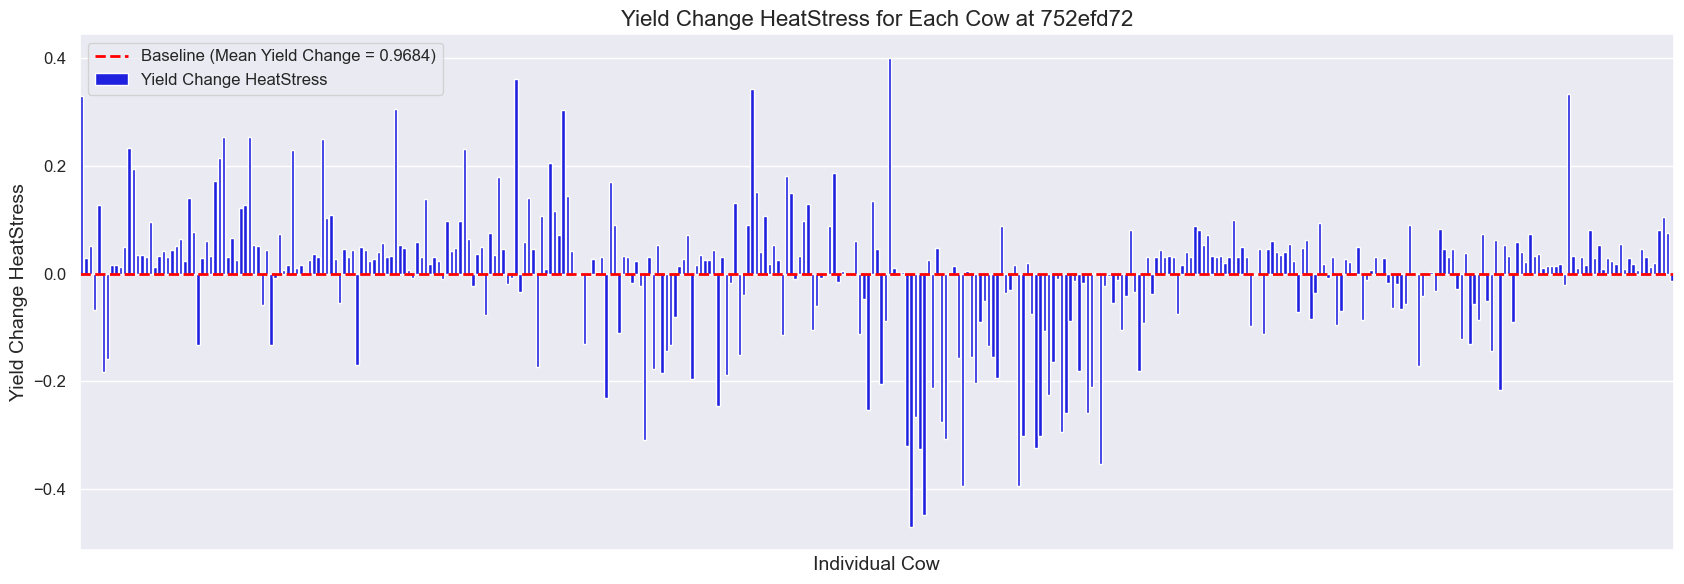

In [ ]:
# Calculate the baseline (mean yield change)
baseline_yield_change = results_df['Yield Change HeatStress'].mean()

# Calculate deviations from the baseline
results_df['Deviation from Baseline'] = results_df['Yield Change HeatStress'] - baseline_yield_change

# Plotting
plt.figure(figsize=(17, 6))
sns.barplot(x=results_df.index, y=results_df['Deviation from Baseline'], color='blue', label='Yield Change HeatStress')

# Add baseline line
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield Change = {baseline_yield_change:.4f})')

# Formatting the plot
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Yield Change HeatStress', fontsize=14)
plt.title(f'Yield Change HeatStress for Each Cow at {farm}', fontsize=16)


plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

## Farm f454e660

In [ ]:
# Select a farm and filter data for that farm
farm = 'f454e660'
daily_farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm].copy()

# Filter data for HeatStress condition
data_heatstress = daily_farm_data[daily_farm_data['HeatStress'] == 1].copy()

# Extract and transform the 'YearSeason' to numeric encoding
def extract_season_numeric(yearseason):
    return int(yearseason.split('-')[1])

# Apply the transformation and keep both the original and new columns
data_heatstress['YearSeason_numeric'] = data_heatstress['YearSeason'].apply(extract_season_numeric)

# Drop the original 'YearSeason' column if not needed
data_heatstress.drop(columns=['YearSeason'], inplace=True)

# Rename the new column to 'YearSeason'
data_heatstress.rename(columns={'YearSeason_numeric': 'YearSeason'}, inplace=True)

# Ensure the features to be scaled are float type
features_to_scale = ['Age', 'DaysInMilk', 'LactationNumber', 'MeanTemperature', 'MeanTHI_adj']
data_heatstress[features_to_scale] = data_heatstress[features_to_scale].astype(float)

# Split data into train and validation sets
train_heatstress, val_heatstress = train_test_split(data_heatstress, test_size=0.3, random_state=42)

# Scale features before the loop
scaler = StandardScaler()
train_heatstress.loc[:, features_to_scale] = scaler.fit_transform(train_heatstress[features_to_scale])
val_heatstress.loc[:, features_to_scale] = scaler.transform(val_heatstress[features_to_scale])

# All possible features excluding 'HeatStress'
all_feats = ['HW', 'cum_HW', 'DaysInMilk', 'LactationNumber', 'MeanTemperature', 'MeanTHI_adj', 'Age', 'YearSeason']

def generate_feature_combinations():
    combos = []
    for hw in ['HW', 'cum_HW']:
        for lact in ['LactationNumber', 'Age']:
            for temp in ['MeanTemperature', 'MeanTHI_adj']:
                remaining_feats = set(all_feats) - {'HW', 'cum_HW', 'LactationNumber', 'Age', 'MeanTemperature', 'MeanTHI_adj'}
                remaining_feats.add(hw)
                remaining_feats.add(lact)
                remaining_feats.add(temp)
                combos.append(list(remaining_feats))
    return combos

feature_combinations = generate_feature_combinations()

# Dictionary to save posterior results
all_cows_results = {f'combo_{i+1}': {} for i in range(len(feature_combinations))}

# Function to fit the Bayesian Linear Regression model
def fit_bayesian_model(daily_cow_data, selected_feats, cow):
    cow_mean = daily_cow_data['NormalizedDailyYield'].mean()
    cow_variance = daily_cow_data['NormalizedDailyYield'].var()
    if cow_variance < 1e-6:
        cow_variance = 1e-6  # Set a minimum threshold to avoid division by zero
    beta = 1 / cow_variance

    # Calculate prior means and standard deviations for the features
    prior_mean_values = [daily_cow_data[feature].mean() for feature in selected_feats]
    prior_std_values = [daily_cow_data[feature].std() for feature in selected_feats]

    # Define priors
    prior_mean = np.array([cow_mean] + prior_mean_values).reshape(-1, 1)
    prior_cov = np.eye(len(selected_feats) + 1) * 0.01  # Stronger regularization

    # Print prior means and standard deviations
    print(f"\nPrior Mean and Standard Deviation for cow {cow} with features {selected_feats}:\n")
    for feature, mean, std in zip(['Off-set'] + selected_feats, prior_mean.flatten(), [np.sqrt(cow_variance)] + prior_std_values):
        print(f"{feature}: mean = {mean}, std_dev = {std}")

    # Instantiate and fit Bayesian Linear Regression model
    BM = BayesianLinearRegression(
        dataframe=daily_cow_data,
        subject_name=cow,
        selected_features=selected_feats,
        target='NormalizedDailyYield',
        subject_type='cow',
        prior_mean=prior_mean,
        prior_cov=prior_cov,
        beta=beta,
        baseline_feature='FarmHeatStressMilkProduction'
    )
    
    try:
        result = BM.fit_model()
    except ValueError as e:
        if str(e) == "math domain error":
            result = {}
            for i in range(BM.Phi.shape[1]):
                mu = BM.posterior_mean[i]
                variance = BM.posterior_cov[i, i]
                if variance < 0:
                    variance = 0  # Ensure variance is non-negative
                sigma = math.sqrt(variance)
                feature_name = "Off-set" if i == 0 else BM.selected_features[i - 1]
                result[feature_name] = {"mu": mu[0], "sigma": sigma}

    # Print posterior means and standard deviations
    print(f"\nPosterior Mean and Standard Deviation for cow {cow} with features {selected_feats}:\n")
    for feature, stats in result.items():
        print(f"{feature}: mean = {stats['mu']}, std_dev = {stats['sigma']}")

    return result

# Function to randomly select one cow and fit the model
def fit_model_for_random_cow(selected_feats, condition):
    cows_list = train_heatstress['SE_Number'].unique()
    
    random_cow = np.random.choice(cows_list)
    daily_cow_data = train_heatstress[train_heatstress['SE_Number'] == random_cow].copy()
    
    print(f"\nSelected random cow: {random_cow} for condition: {condition} and features: {selected_feats}")
    
    return fit_bayesian_model(daily_cow_data, selected_feats, random_cow)

# Iterate over each combination and fit the model for one random cow in each condition
for combo_index, selected_feats in enumerate(feature_combinations, start=1):
    print(f"\nProcessing combination {combo_index}/{len(feature_combinations)}: {selected_feats}")
    all_cows_results[f'combo_{combo_index}'] = fit_model_for_random_cow(selected_feats, "HeatStress")


Processing combination 1/8: ['YearSeason', 'HW', 'MeanTemperature', 'LactationNumber', 'DaysInMilk']

Selected random cow: SE-f454e660-0754 for condition: HeatStress and features: ['YearSeason', 'HW', 'MeanTemperature', 'LactationNumber', 'DaysInMilk']

Prior Mean and Standard Deviation for cow SE-f454e660-0754 with features ['YearSeason', 'HW', 'MeanTemperature', 'LactationNumber', 'DaysInMilk']:

Off-set: mean = 0.9949499769467618, std_dev = 0.2389944840803059
YearSeason: mean = 3.1666666666666665, std_dev = 0.408248290463863
HW: mean = 0.0, std_dev = 0.0
MeanTemperature: mean = -0.0385021853554608, std_dev = 0.484565146483131
LactationNumber: mean = -0.9503951428465287, std_dev = 0.0
DaysInMilk: mean = 0.6537347222017313, std_dev = 0.2969765949800317

Posterior Mean and Standard Deviation for cow SE-f454e660-0754 with features ['YearSeason', 'HW', 'MeanTemperature', 'LactationNumber', 'DaysInMilk']:

Off-set: mean = 1.1283946245264465, std_dev = 0.29045839154557596
YearSeason: mean

In [ ]:
# Function to fit the Bayesian Linear Regression model for cross-validation
def fit_bayesian_model_cv(daily_cow_data, selected_feats):
    cow_mean = daily_cow_data['NormalizedDailyYield'].mean()
    cow_variance = daily_cow_data['NormalizedDailyYield'].var()
    if cow_variance < 1e-6:
        cow_variance = 1e-6  # Set a minimum threshold to avoid division by zero
    beta = 1 / cow_variance

    prior_mean_values = [daily_cow_data[feature].mean() for feature in selected_feats]
    prior_mean = np.array([cow_mean] + prior_mean_values).reshape(-1, 1)
    prior_cov = np.eye(len(selected_feats) + 1) * 0.01  # Stronger regularization

    model = SklearnBayesianLinearRegression(
        dataframe=daily_cow_data,
        subject_name='farm',
        selected_features=selected_feats,
        target='NormalizedDailyYield',
        subject_type='cow',
        prior_mean=prior_mean,
        prior_cov=prior_cov,
        beta=beta,
        baseline_feature='FarmHeatStressMilkProduction'
    )

    return model

# Function to perform cross-validation
def cross_validate_feature_combinations(val_data, feature_combinations):
    best_features = None
    lowest_mse = float('inf')

    for features in feature_combinations:
        val_data_scaled = val_data.copy()

        X_val = val_data_scaled[features].astype(np.float64).values
        y_val = val_data_scaled['NormalizedDailyYield'].astype(np.float64).values

        model = fit_bayesian_model_cv(val_data_scaled, features)

        cv_scores = cross_val_score(model, X_val, y_val, cv=5, scoring='neg_mean_squared_error')
        mean_cv_score = -cv_scores.mean()
        std_cv_score = cv_scores.std()

        print(f"Cross-validation MSE for features {features}: {mean_cv_score:.4f} ± {std_cv_score:.4f}")

        if mean_cv_score < lowest_mse:
            lowest_mse = mean_cv_score
            best_features = features

    return best_features, lowest_mse

# Perform cross-validation and select the best feature combination
best_features_heatstress, lowest_mse_heatstress = cross_validate_feature_combinations(val_heatstress, feature_combinations)
print(f"\nThe best feature combination in terms of the lowest MSE for HeatStress is {best_features_heatstress} with an MSE of {lowest_mse_heatstress:.4f}.\n")

Cross-validation MSE for features ['YearSeason', 'HW', 'MeanTemperature', 'LactationNumber', 'DaysInMilk']: 0.0620 ± 0.0046
Cross-validation MSE for features ['YearSeason', 'HW', 'LactationNumber', 'DaysInMilk', 'MeanTHI_adj']: 0.0620 ± 0.0048
Cross-validation MSE for features ['YearSeason', 'HW', 'MeanTemperature', 'DaysInMilk', 'Age']: 0.0620 ± 0.0046
Cross-validation MSE for features ['YearSeason', 'HW', 'DaysInMilk', 'MeanTHI_adj', 'Age']: 0.0619 ± 0.0048
Cross-validation MSE for features ['YearSeason', 'MeanTemperature', 'LactationNumber', 'DaysInMilk', 'cum_HW']: 0.0620 ± 0.0046
Cross-validation MSE for features ['YearSeason', 'LactationNumber', 'DaysInMilk', 'MeanTHI_adj', 'cum_HW']: 0.0620 ± 0.0048
Cross-validation MSE for features ['Age', 'YearSeason', 'MeanTemperature', 'DaysInMilk', 'cum_HW']: 0.0620 ± 0.0046
Cross-validation MSE for features ['Age', 'YearSeason', 'DaysInMilk', 'MeanTHI_adj', 'cum_HW']: 0.0619 ± 0.0048

The best feature combination in terms of the lowest MSE

In [ ]:
# Function to fit model on entire dataset and calculate yield change for each cow
def fit_model_and_calculate_yield_change(data, features):
    cow_ids = data['SE_Number'].unique()
    yield_changes = {}
    
    for cow in cow_ids:
        cow_data = data[data['SE_Number'] == cow]
        
        # Calculate cow's individual mean and variance for NormalizedDailyYield
        cow_mean = cow_data['NormalizedDailyYield'].mean()
        cow_variance = cow_data['NormalizedDailyYield'].var()
        if cow_variance < 1e-6:
            cow_variance = 1e-6  # Set a minimum threshold to avoid division by zero
        beta = 1 / cow_variance

        # Calculate prior means for the features
        prior_mean_values = [cow_data[feature].mean() for feature in features]
        
        # Define priors
        prior_mean = np.array([cow_mean] + prior_mean_values).reshape(-1, 1)
        prior_cov = np.eye(len(features) + 1) * 0.01  # Stronger regularization
        
        # Initialize and fit the model on the entire dataset with the best features
        model = BayesianLinearRegression(
            dataframe=cow_data,
            subject_name=cow,
            selected_features=features,
            target='NormalizedDailyYield',
            subject_type='cow',
            prior_mean=prior_mean,
            prior_cov=prior_cov,
            beta=beta,
            baseline_feature='FarmHeatStressMilkProduction'
        )
        result = model.fit_model()
        
        # Store the yield change for the cow
        yield_changes[cow] = result['Off-set']['mu']
    
    return yield_changes

# Fit the best model on the entire dataset using the best features from Block 2
yield_changes_heatstress = fit_model_and_calculate_yield_change(
    data_heatstress.copy(), best_features_heatstress
)

# Create results DataFrame
results_df = pd.DataFrame({
    'SE_Number': yield_changes_heatstress.keys(),
    'Yield Change HeatStress': yield_changes_heatstress.values()
})

results_df

,SE_Number,Yield Change HeatStress
0,SE-a2bab923-0680,0.937796
1,SE-f454e660-0139,0.927593
2,SE-f454e660-0157,0.896808
3,SE-f454e660-0235,1.035353
4,SE-f454e660-0250,1.046979
...,...,...
197,SE-f454e660-701,1.001089
198,SE-f454e660-712,0.999986
199,SE-f454e660-714,1.000020
200,SE-f454e660-735,0.870759


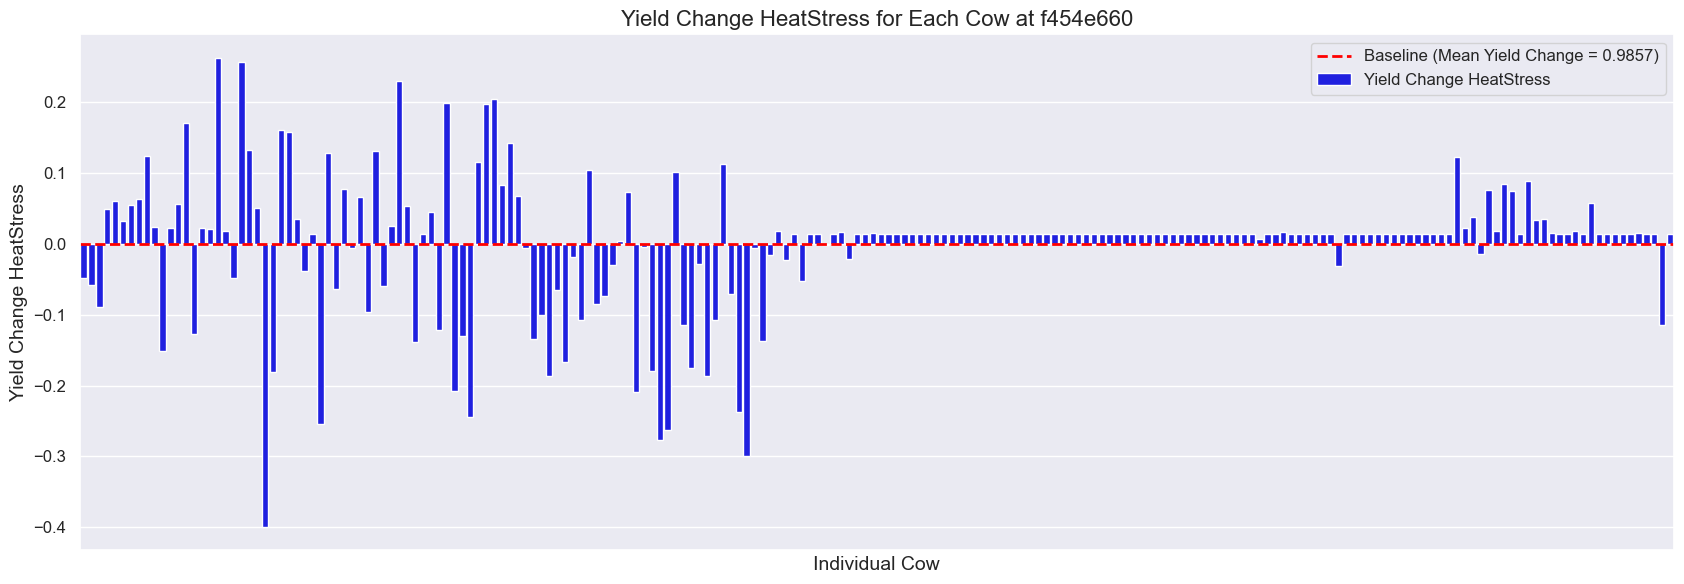

In [ ]:
# Calculate the baseline (mean yield change)
baseline_yield_change = results_df['Yield Change HeatStress'].mean()

# Calculate deviations from the baseline
results_df['Deviation from Baseline'] = results_df['Yield Change HeatStress'] - baseline_yield_change

# Plotting
plt.figure(figsize=(17, 6))
sns.barplot(x=results_df.index, y=results_df['Deviation from Baseline'], color='blue', label='Yield Change HeatStress')

# Add baseline line
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield Change = {baseline_yield_change:.4f})')

# Formatting the plot
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Yield Change HeatStress', fontsize=14)
plt.title(f'Yield Change HeatStress for Each Cow at {farm}', fontsize=16)


plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()